In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
import os
from glob import glob
import io
import numpy as np
from io import BytesIO

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max.colwidth',100)
pd.options.display.max_columns = 100

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/var/folders/yv/8sn4_mf155d8ltwrkhtfcqm00000gn/T/ipykernel_28179/1322028696.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

2024-04-02 16:26:31.678173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from keras.models import Sequential
from keras import metrics
from keras import optimizers
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import os

# Importing data

In [4]:
df = pd.read_csv('/Users/wuyuemeng/Desktop/project/real_dataset2/train_set.csv', encoding='utf-8-sig')
df = df.sample(frac=1).reset_index(drop=True)
df.head()
df.shape

,Unnamed: 0.1,Unnamed: 0,category_id,thumbnail
0,3368,7784,1,https://i.ytimg.com/vi/43ZUs-l2pXU/hqdefault.jpg?sqp=-oaymwEcCNACELwBSFXyq4qpAw4IARUAAIhCGAFwAcA...
1,2744,21089,2,https://i.ytimg.com/vi/yvycLaoVrLs/hqdefault.jpg?sqp=-oaymwEcCNACELwBSFXyq4qpAw4IARUAAIhCGAFwAcA...
2,4239,20097,2,https://i.ytimg.com/vi/CtyFXQ00md4/hqdefault.jpg?sqp=-oaymwEcCNACELwBSFXyq4qpAw4IARUAAIhCGAFwAcA...
3,3148,22185,2,https://i.ytimg.com/vi/gaFjIEJHzHo/hqdefault.jpg?sqp=-oaymwEcCNACELwBSFXyq4qpAw4IARUAAIhCGAFwAcA...
4,2440,5875,0,https://i.ytimg.com/vi/_Tu0HLDCkrA/hqdefault.jpg?sqp=-oaymwEcCNACELwBSFXyq4qpAw4IARUAAIhCGAFwAcA...


(17813, 4)

In [5]:
category = df['category_id']
thumbnail = df['thumbnail']

- load data

In [7]:
image_w = 64 
image_h = 64
data_tensors = []

for i in thumbnail :
    
    url = i+str('.jpg')
    response = requests.get(url, stream=True) 
    img= Image.open(io.BytesIO(response.content)) 
    
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    img = image.img_to_array(img)

    img = preprocess_input(img)
    data_tensors.append(img)
    

In [8]:
X = np.array(data_tensors)
Y = np.array(category)
Y = pd.get_dummies(Y).to_numpy()

In [9]:
X.shape
Y.shape

(17813, 64, 64, 3)

(17813, 3)

- Split data into train and test set

In [10]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, Y)
X_train.shape

(13359, 64, 64, 3)

In [11]:
xy = (X_train, X_test, y_train, y_test)
np.save("/Users/wuyuemeng/Desktop/project/image_train_test_split.npy", xy)

/Users/wuyuemeng/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [45]:
X_train, X_valid, y_train, y_valid = np.load("image_train_test_split.npy", allow_pickle=True)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((13359, 64, 64, 3), (4454, 64, 64, 3), (13359, 3), (4454, 3))

In [46]:
# Specifying a category
categories = np.sort(category.unique())
classes_num = len(categories)

# Normalizing data (between 0 and 1)
X_train = X_train.astype("float") / 64.0
X_valid  = X_valid.astype("float")  / 64.0
print('X_train shape:', X_train.shape) 
print('X_valid shape:', X_valid.shape)
categories, classes_num

X_train shape: (13359, 64, 64, 3)
X_valid shape: (4454, 64, 64, 3)


(array([0, 1, 2]), 3)

# CNN Model training and testing

In [47]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3))) 
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully-connected layer
model.add(Flatten())    # In vector form reshape
model.add(Dense(512))   # Output
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(classes_num))
model.add(Activation('softmax'))
# Building a model
learning_rate = 0.001
optimizer = RMSprop(learning_rate=learning_rate)  # Specifying an optimization function
model.compile(loss='categorical_crossentropy',   
    optimizer=optimizer,
    metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 activation_30 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 dropout_18 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 activation_31 (Activation)  (None, 32, 32, 64)        0         
                                                      

- Batch size: 32

Epoch 1/20
418/418 [==============================] - 191s 454ms/step - loss: 0.7403 - accuracy: 0.7253 - val_loss: 0.5466 - val_accuracy: 0.7822
Epoch 2/20
418/418 [==============================] - 183s 437ms/step - loss: 0.4471 - accuracy: 0.8324 - val_loss: 0.3906 - val_accuracy: 0.8577
Epoch 3/20
418/418 [==============================] - 181s 432ms/step - loss: 0.3547 - accuracy: 0.8667 - val_loss: 0.3415 - val_accuracy: 0.8731
Epoch 4/20
418/418 [==============================] - 169s 403ms/step - loss: 0.2903 - accuracy: 0.8960 - val_loss: 0.5047 - val_accuracy: 0.7979
Epoch 5/20
418/418 [==============================] - 161s 384ms/step - loss: 0.2369 - accuracy: 0.9143 - val_loss: 0.3314 - val_accuracy: 0.8774
Epoch 6/20
418/418 [==============================] - 184s 441ms/step - loss: 0.1808 - accuracy: 0.9346 - val_loss: 0.3712 - val_accuracy: 0.8642
Epoch 7/20
418/418 [==============================] - 183s 438ms/step - loss: 0.1476 - accuracy: 0.9481 - val_loss: 0.4421 -

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

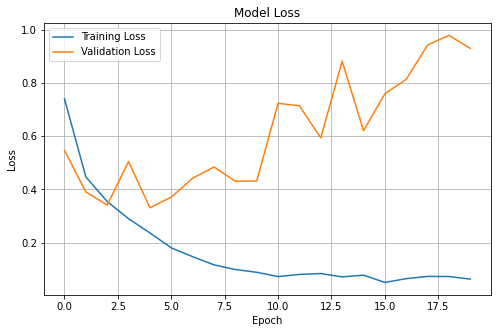

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

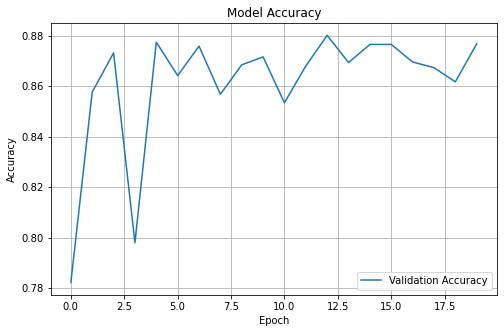

In [15]:
history1 = model.fit(X_train, y_train, batch_size=32, epochs=20 , validation_data=(X_valid, y_valid))
df_history = pd.DataFrame(history1.history)
# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(df_history['loss'], label='Training Loss')
plt.plot(df_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(df_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Evaluating the model
score = model.evaluate(X_valid, y_valid)
print('loss=', score[0])        
print('accuracy=', score[1])   

140/140 [==============================] - 10s 73ms/step - loss: 0.9294 - accuracy: 0.8767
loss= 0.9294494986534119
accuracy= 0.876740038394928


In [17]:
model.save('/Users/wuyuemeng/Desktop/project/my_model.h5')

/Users/wuyuemeng/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


- Batch size: 8

Epoch 1/20
1670/1670 [==============================] - 311s 186ms/step - loss: 0.6892 - accuracy: 0.7384 - val_loss: 0.5408 - val_accuracy: 0.8139
Epoch 2/20
1670/1670 [==============================] - 310s 185ms/step - loss: 0.5189 - accuracy: 0.8162 - val_loss: 0.4301 - val_accuracy: 0.8348
Epoch 3/20
1670/1670 [==============================] - 312s 187ms/step - loss: 0.4954 - accuracy: 0.8322 - val_loss: 0.4117 - val_accuracy: 0.8415
Epoch 4/20
1670/1670 [==============================] - 312s 187ms/step - loss: 0.4803 - accuracy: 0.8419 - val_loss: 0.3728 - val_accuracy: 0.8635
Epoch 5/20
1670/1670 [==============================] - 314s 188ms/step - loss: 0.4695 - accuracy: 0.8466 - val_loss: 0.4381 - val_accuracy: 0.8485
Epoch 6/20
1670/1670 [==============================] - 311s 186ms/step - loss: 0.4791 - accuracy: 0.8486 - val_loss: 0.4217 - val_accuracy: 0.8422
Epoch 7/20
1670/1670 [==============================] - 313s 187ms/step - loss: 0.5043 - accuracy: 0.8415 - val_

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

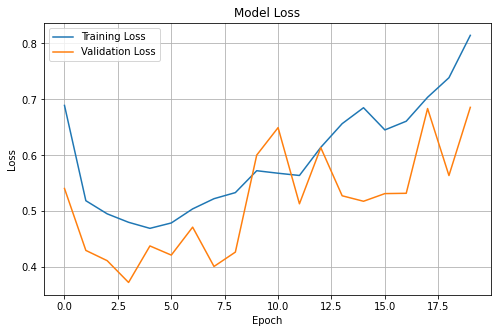

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

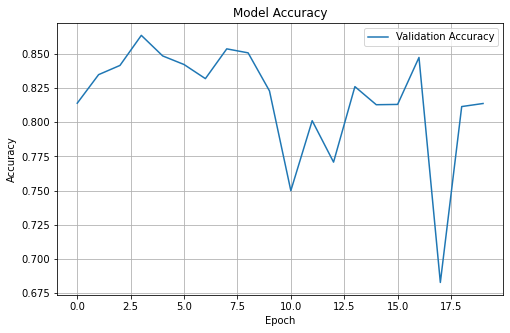

In [48]:
history4 = model.fit(X_train, y_train, batch_size=8, epochs=20 , validation_data=(X_valid, y_valid))
df_history4 = pd.DataFrame(history4.history)
# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(df_history4['loss'], label='Training Loss')
plt.plot(df_history4['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()
# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(df_history4['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Evaluating the model
score = model.evaluate(X_valid, y_valid)
print('loss=', score[0])        
print('accuracy=', score[1])    

140/140 [==============================] - 12s 83ms/step - loss: 0.6857 - accuracy: 0.8137
loss= 0.6857361793518066
accuracy= 0.8136506676673889


In [50]:
model.save('/Users/wuyuemeng/Desktop/project/my_model3.h5')

- Batch size: 128

Epoch 1/20
105/105 [==============================] - 150s 1s/step - loss: 1.0939 - accuracy: 0.6253 - val_loss: 0.7854 - val_accuracy: 0.6823
Epoch 2/20
105/105 [==============================] - 145s 1s/step - loss: 0.6125 - accuracy: 0.7514 - val_loss: 0.4969 - val_accuracy: 0.8184
Epoch 3/20
105/105 [==============================] - 131s 1s/step - loss: 0.4750 - accuracy: 0.8147 - val_loss: 0.4648 - val_accuracy: 0.8455
Epoch 4/20
105/105 [==============================] - 141s 1s/step - loss: 0.3888 - accuracy: 0.8519 - val_loss: 0.4041 - val_accuracy: 0.8453
Epoch 5/20
105/105 [==============================] - 150s 1s/step - loss: 0.3284 - accuracy: 0.8763 - val_loss: 0.4360 - val_accuracy: 0.8264
Epoch 6/20
105/105 [==============================] - 118s 1s/step - loss: 0.2755 - accuracy: 0.8981 - val_loss: 0.4197 - val_accuracy: 0.8453
Epoch 7/20
105/105 [==============================] - 144s 1s/step - loss: 0.2184 - accuracy: 0.9177 - val_loss: 0.3350 - val_accuracy: 0.8705

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

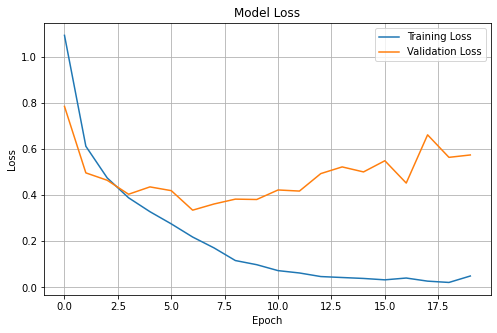

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

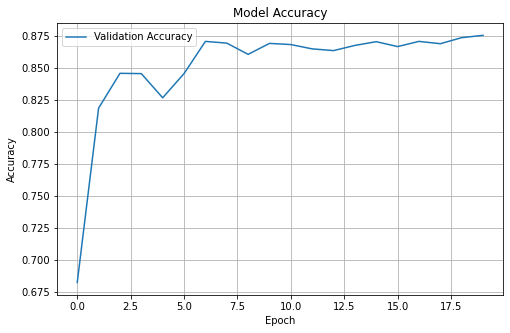

In [32]:
history5 = model.fit(X_train, y_train, batch_size=128, epochs=20 , validation_data=(X_valid, y_valid))
df_history5 = pd.DataFrame(history5.history)
# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(df_history5['loss'], label='Training Loss')
plt.plot(df_history5['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()
# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(df_history5['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Evaluating the model
score = model.evaluate(X_valid, y_valid)
print('loss=', score[0])        
print('accuracy=', score[1])    

140/140 [==============================] - 12s 86ms/step - loss: 0.5746 - accuracy: 0.8752
loss= 0.5746409296989441
accuracy= 0.8751683831214905


In [34]:
model.save('/Users/wuyuemeng/Desktop/project/my_model4.h5')

- Batch size: 64

Epoch 1/20
209/209 [==============================] - 162s 762ms/step - loss: 0.8733 - accuracy: 0.6792 - val_loss: 0.5342 - val_accuracy: 0.8031
Epoch 2/20
209/209 [==============================] - 152s 727ms/step - loss: 0.4993 - accuracy: 0.8081 - val_loss: 0.4403 - val_accuracy: 0.8413
Epoch 3/20
209/209 [==============================] - 125s 594ms/step - loss: 0.3852 - accuracy: 0.8558 - val_loss: 0.4259 - val_accuracy: 0.8449
Epoch 4/20
209/209 [==============================] - 153s 731ms/step - loss: 0.3152 - accuracy: 0.8834 - val_loss: 0.3755 - val_accuracy: 0.8563
Epoch 5/20
209/209 [==============================] - 154s 738ms/step - loss: 0.2557 - accuracy: 0.9055 - val_loss: 0.3788 - val_accuracy: 0.8714
Epoch 6/20
209/209 [==============================] - 156s 747ms/step - loss: 0.1939 - accuracy: 0.9284 - val_loss: 0.3644 - val_accuracy: 0.8653
Epoch 7/20
209/209 [==============================] - 155s 740ms/step - loss: 0.1475 - accuracy: 0.9472 - val_loss: 0.3777 -

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

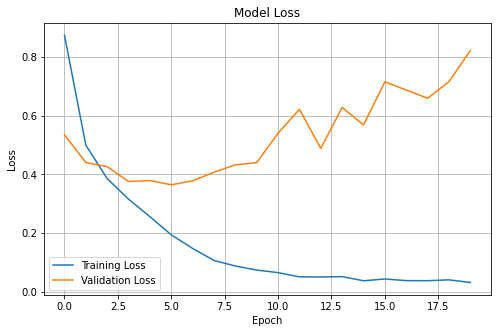

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

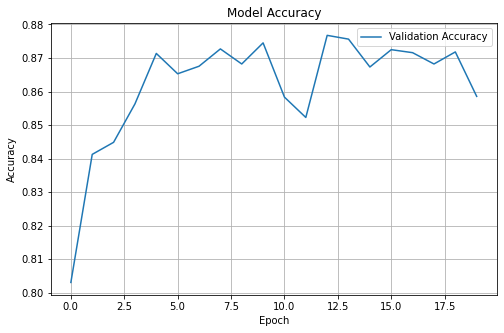

In [21]:
history2 = model.fit(X_train, y_train, batch_size=64, epochs=20 , validation_data=(X_valid, y_valid))
df_history2 = pd.DataFrame(history2.history)
# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(df_history2['loss'], label='Training Loss')
plt.plot(df_history2['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(df_history2['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Evaluating the model
score = model.evaluate(X_valid, y_valid)
print('loss=', score[0])       
print('accuracy=', score[1])   

140/140 [==============================] - 10s 73ms/step - loss: 0.8214 - accuracy: 0.8586
loss= 0.8214033842086792
accuracy= 0.8585541248321533


In [23]:
model.save('/Users/wuyuemeng/Desktop/project/my_model1.h5')

- Batch size: 16

Epoch 1/20
835/835 [==============================] - 218s 260ms/step - loss: 0.7430 - accuracy: 0.7414 - val_loss: 0.4961 - val_accuracy: 0.8321
Epoch 2/20
835/835 [==============================] - 218s 261ms/step - loss: 0.4593 - accuracy: 0.8345 - val_loss: 0.3984 - val_accuracy: 0.8543
Epoch 3/20
835/835 [==============================] - 219s 262ms/step - loss: 0.3815 - accuracy: 0.8638 - val_loss: 0.4038 - val_accuracy: 0.8500
Epoch 4/20
835/835 [==============================] - 226s 271ms/step - loss: 0.3507 - accuracy: 0.8772 - val_loss: 0.3990 - val_accuracy: 0.8525
Epoch 5/20
835/835 [==============================] - 227s 272ms/step - loss: 0.3327 - accuracy: 0.8856 - val_loss: 0.4150 - val_accuracy: 0.8559
Epoch 6/20
835/835 [==============================] - 223s 267ms/step - loss: 0.3114 - accuracy: 0.8930 - val_loss: 0.3781 - val_accuracy: 0.8633
Epoch 7/20
835/835 [==============================] - 228s 273ms/step - loss: 0.2907 - accuracy: 0.9032 - val_loss: 0.3953 -

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

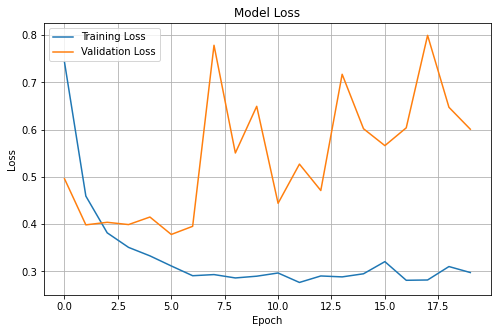

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

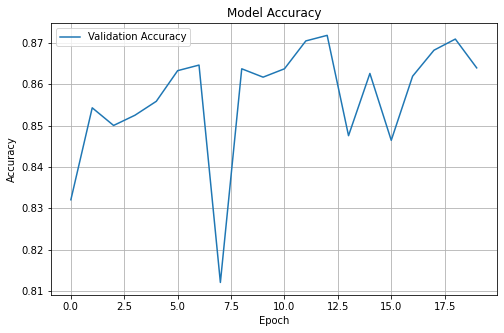

In [38]:
history3 = model.fit(X_train, y_train, batch_size=16, epochs=20 , validation_data=(X_valid, y_valid))
df_history3 = pd.DataFrame(history3.history)
# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(df_history3['loss'], label='Training Loss')
plt.plot(df_history3['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(df_history3['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Evaluating the model
score = model.evaluate(X_valid, y_valid)
print('loss=', score[0])        
print('accuracy=', score[1])    

140/140 [==============================] - 10s 74ms/step - loss: 0.6009 - accuracy: 0.8639
loss= 0.6009343862533569
accuracy= 0.8639425039291382


In [40]:
model.save('/Users/wuyuemeng/Desktop/project/my_model2.h5')

- load model

In [51]:
model = load_model('/Users/wuyuemeng/Desktop/project/my_model.h5')

- Test a random thumbnail

In [52]:
image_w = 64 
image_h = 64
pixels = image_w * image_h * 3

i = "https://i.ytimg.com/vi/cWNpW-vV5tQ/hqdefault.jpg?sqp=-oaymwEcCNACELwBSFXyq4qpAw4IARUAAIhCGAFwAcABBg==&rs=AOn4CLCT95v2PFPwugF2PmZ4mzMVtm56Yw"
# category: food

url = i+str('.jpg')
response = requests.get(url, stream=True) 
test_img= Image.open(io.BytesIO(response.content)) 

test_img = test_img.convert("RGB")
test_img = test_img.resize((image_w, image_h))
test_img = image.img_to_array(test_img)

test_img = preprocess_input(test_img)
test_img = test_img.astype("float") / 64.0
test_img = test_img.reshape(-1, 64, 64, 3)
test_img.shape

(1, 64, 64, 3)

In [53]:
pred = model.predict(test_img)  
pred
result = [np.argmax(value) for value in pred]   # Returns the class with the highest predicted value
print('data category : ',categories[result[0]])
# category ( 0: sport , 1: pet, 2: food )

1/1 [==============================] - 1s 774ms/step


array([[4.0668265e-06, 1.7226212e-05, 9.9997866e-01]], dtype=float32)

data category :  2
